In [ ]:
!git clone "https://github.com/Ankushdas178/bengali-abusive-comment-detection"

Cloning into 'bengali-abusive-comment-detection'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 31.91 KiB | 15.95 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer



# Load datasets
abusive_df = pd.read_csv('/content/bengali-abusive-comment-detection/Abusive_Merged_Classes-new.csv')
non_abusive_df = pd.read_csv('/content/bengali-abusive-comment-detection/Non_abusive - Sheet1.csv')

In [ ]:
# Standardize column names for consistency
abusive_df.columns = ['Comment', 'Class']
non_abusive_df.columns = ['Comment', 'Class']
# Combine datasets and replace NaN in non-abusive with "Non abusive"
# Ensure no missing values in the 'Class' column for the non-abusive dataset
non_abusive_df['Class'].fillna('Non abusive', inplace=True)

# Combine the datasets
df = pd.concat([abusive_df, non_abusive_df], ignore_index=True)

<ipython-input-3-127803c9cec8>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  non_abusive_df['Class'].fillna('Non abusive', inplace=True)


In [ ]:
# Verify and ensure no missing values or unexpected classes
df['Class'] = df['Class'].fillna('Non abusive')  # Fill any remaining NaN values
assert df['Class'].isna().sum() == 0, "There are still missing values in the 'Class' column."


In [ ]:
# Preprocessing
def clean_text(text):
    # Ensure text is a string
    text = str(text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Lowercase the text
    text = text.lower()
    return text

# Apply the clean_text function
df['Comment'] = df['Comment'].apply(clean_text)

In [ ]:
# Encode labels dynamically based on unique classes in the dataset
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])
num_classes = len(label_encoder.classes_)


In [ ]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Comment']).toarray()
y = df['Class']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train SVM model
model = SVC(kernel='linear', probability=False)  # Use a linear kernel for better performance on text data
model.fit(X_train, y_train)


SVC(kernel='linear')

In [ ]:
y_pred = model.predict(X_test)

# Ensure that target names are strings
target_names = [str(label) for label in label_encoder.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))


                precision    recall  f1-score   support

Gender abusive       0.79      0.65      0.71        80
   Non abusive       0.64      0.73      0.68        62
 Personal Hate       0.57      0.62      0.59        71

      accuracy                           0.66       213
     macro avg       0.67      0.67      0.66       213
  weighted avg       0.67      0.66      0.66       213



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate overall precision, recall, and F1 score
overall_precision = precision_score(y_test, y_pred, average='weighted')
overall_recall = recall_score(y_test, y_pred, average='weighted')
overall_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall Recall: {overall_recall:.2f}")
print(f"Overall F1 Score: {overall_f1:.2f}")

Overall Precision: 0.67
Overall Recall: 0.66
Overall F1 Score: 0.66


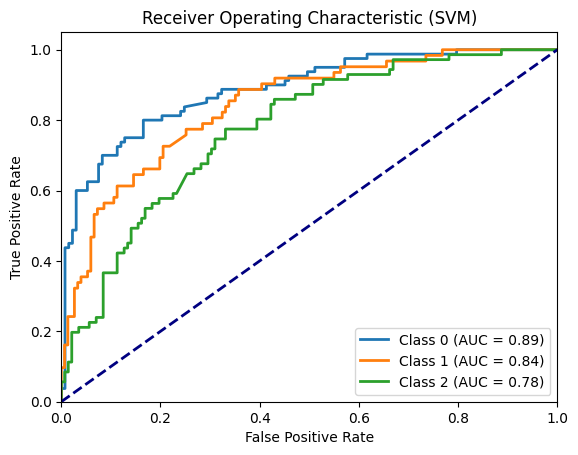

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Replace with your classes
n_classes = y_test_binarized.shape[1]

# Ensure the SVM model supports probabilities
model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))  # Example setup
model.fit(X_train, y_train)  # Ensure the model is trained on your training data

# Get the probability predictions
y_probs = model.predict_proba(X_test)  # `predict_proba` provides probabilities for each class

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (SVM)')
plt.legend(loc="lower right")
plt.show()


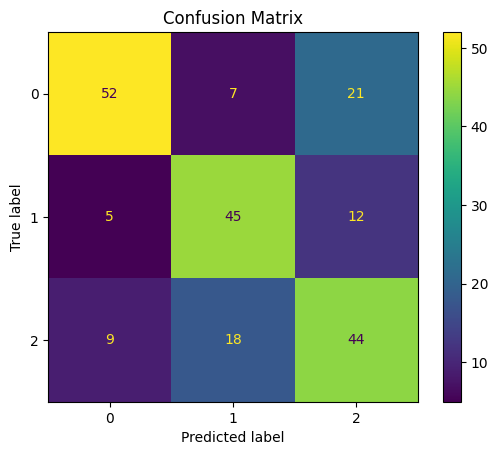

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you already have 'y_true' and 'y_pred' defined
# In this case, y_pred is already a 1D array of predicted class labels
y_pred_classes = y_pred  # Directly use y_pred as it is already class labels
y_true_classes = y_test  # Ensure y_test is also a 1D array of true class labels

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# --- Prediction for new input ---
\
def predict_class(comment):
    cleaned = clean_text(comment)
    vec = vectorizer.transform([cleaned]).toarray()
    prediction = model.predict(vec)
    class_name = label_encoder.inverse_transform(prediction)
    return class_name[0]

# Example: input a Bengali comment
user_input = input("Enter a Bengali comment: ")
predicted_class = predict_class(user_input)
print(f"Predicted Class: {predicted_class}")

Enter a Bengali comment: Sala mere fela uchit shuorer bachha der
Predicted Class: Personal Hate
